# SGD with momentum
Суть метода SGD with momentum заключается в том, чтобы генерируемая последовательность точек имела инерцию. То есть следующая сгенерированная точка должна зависать не только от локального поведения функции, но и от её поведения на предыдущих итераций. Для реализации этого последовательность точек вычисляется следующим образом:
$ v_{i + 1} = \gamma v_i - (1 - \gamma) g_i, w_{i + 1} = w_i - \alpha v_{i + 1}$, где $\gamma \in (0, 1)$ - константа сглаживания.
Добавление инерции может значительно ускорить сходимость.

# Метод Нестерова
Метод Нестерова является небольшой модификацией SGD with momentum. В предыдущем методе мы, очевидно, вычисляем градиент в точке $w_i$. Метод Нестерова предлагает вместо этого вычислять его в точке $w_i - \alpha \gamma v_i$, что может ещё сильнее ускорить сходимость для некоторых функций

# AdaGrad
Метод AdaGrad предлагает способ ускорить сходимость градиентного спуска для овражных функций. Для этого выполняет масштабирование градиента по каждой из координат отдельно, уменьшая координаты, которые слишком большие относительно других.
$w_{i+1} = w_i - \frac{\alpha g_i}{\sqrt{diag(G)}}, G = \Sigma_{j=1}^{i}g_j g_j^T$

# RMSProp
Метод RMSProp предназначен для улучшения сходимости на овражных функциях, как и AdaGrad. При этом $G$ в AdaGrad зачастую достаточно быстро растёт и, следовательно, скорость сходимости падает. RMSProp предлагает исправление, вместо $G$ считать квадрат градиента усреднённый методом из SGD with momentum
$ s_{i+1} = \beta s_i + (1 - \beta) g_i^2, w_{i+1} = w_i - \frac{\alpha g_i}{\sqrt{s_{i+1} + \varepsilon}} $, где $\beta \in (0, 1)$ - константа, $\varepsilon$ - маленькая константа, предназначенная для предотвращения деления на ноль.

# Adam
Метод Adam является объединением идей SGD with momentum и RMSProp, усредняя одновременно и градиент, и его квадрат, а также выравнивает усреднённые значения.
$v_{i+1} = \beta_1 v_i + (1 - \beta_1) g_i, s_{i+1} = \beta_2 s_i + (1 - \beta_2) g_i^2$
$v'_{i+1} = \frac{v_{i+1}}{1 - \beta_1^{i+1}}$
$s'_{i+1} = \frac{s_{i+1}}{1 - \beta_2^{i+1}}$
$w_{i+1} = w_i - \alpha \frac{v'_{i+1}}{\sqrt{s'_{i+1} + \varepsilon}}$

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

from core.gradient_descent import *
from core.visualizer import *
from core.optimizer_evaluator import *
from core.utils import fn_sum
from core.analzyer import *



## Иллюстрация работы модификаций GD в двумерном случае

Best value found: x* = [-0.00655154 -0.03596923] with f(x*) = 0.009875937326992823
Best value found: x* = [0.01429452 0.00839286] with f(x*) = 0.001432537621115081
Best value found: x* = [0.0352464  0.03582856] with f(x*) = 0.009981196071734607
Best value found: x* = [0.03675839 0.0190027 ] with f(x*) = 0.009703274499070862
Best value found: x* = [0.02938466 0.02014392] with f(x*) = 0.005985060430058714
<generator object <lambda>.<locals>.<genexpr> at 0x7fe38d7d4510>


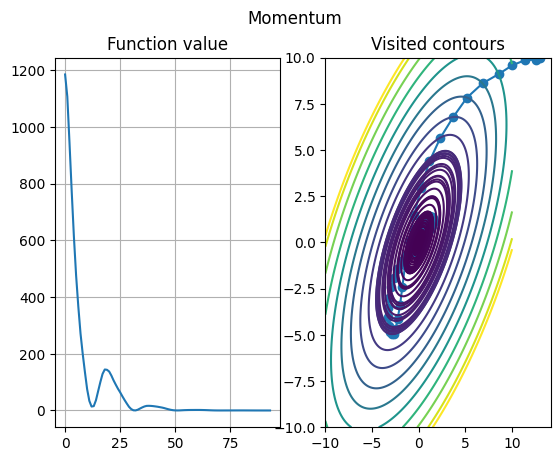

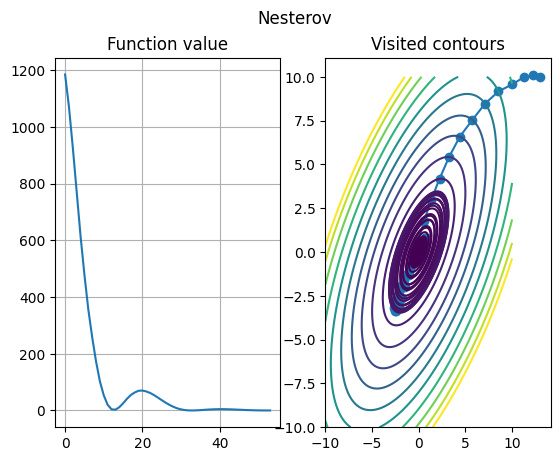

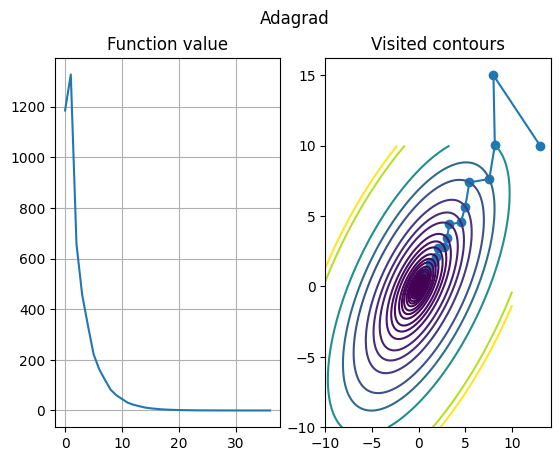

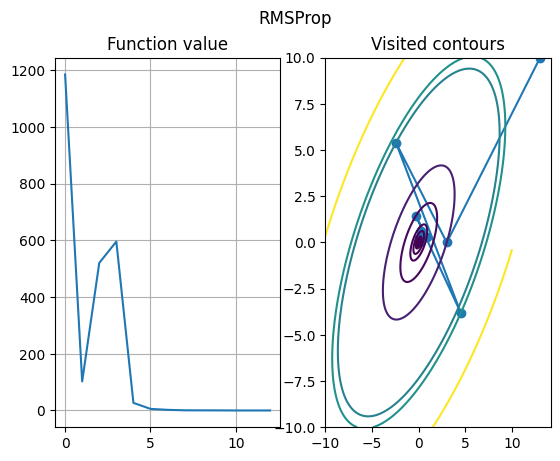

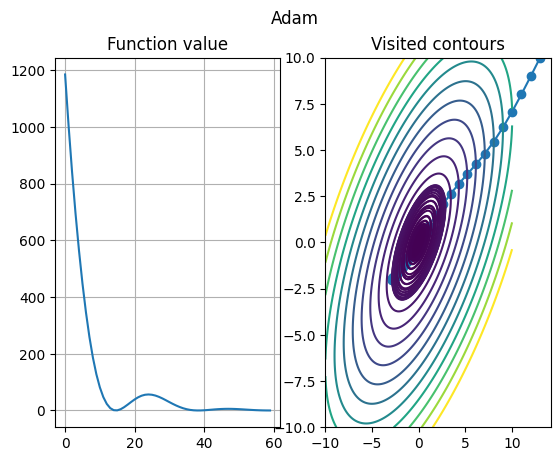

In [19]:
roi=SearchRegion2d((-10, 10), (-10, 10))
x0 = np.array([-5, 5])

f1 = generate_positive_definite_quadratic_form(2, 4, random_orthonormal_basis)
f2 = generate_positive_definite_quadratic_form(2, 6, random_orthonormal_basis)
f3 = generate_positive_definite_quadratic_form(2, 8, random_orthonormal_basis)

fs = [f1, f2, f3]
dfs = [f1.gradient_function(), f2.gradient_function(), f3.gradient_function()]

f = fn_sum(*fs)
df = fn_sum(*dfs)

def terminate(ff, steps):
    return ff(steps[-1]) < 0.01 or len(steps) > 1000

batch = 2
momentum_scheduler = step_learning_scheduler(0.1, 1, 1, batch, len(fs))

momentum = gradient_descent_minibatch_with_momentum(0.3)(
    fs, dfs, batch, x0,
    momentum_scheduler,
    terminate
)

visualize_optimizing_process(f, roi, np.array(momentum)).suptitle('Momentum')

nesterov = gradient_descent_minibatch_with_momentum(0.7, True)(
    fs, dfs, batch, x0,
    momentum_scheduler,
    terminate
)

visualize_optimizing_process(f, roi, np.array(nesterov)).suptitle('Nesterov')

adagrad = gradient_descent_minibatch_adagrad(fs, dfs, batch, x0, exponential_learning_scheduler(7, 0.1, batch, len(fs)), terminate)
visualize_optimizing_process(f, roi, np.array(adagrad)).suptitle('Adagrad')

rmsprop = gradient_descent_minibatch_rms_prop(0.2)(
    fs, dfs, batch, x0,
    exponential_learning_scheduler(1, 0.2, batch, len(fs)),
    terminate
)

visualize_optimizing_process(f, roi, np.array(rmsprop)).suptitle('RMSProp')

adam = steepest_descent_adam(0.9, 0.999)(f, df, x0, bin_search_with_iters(5), terminate)
visualize_optimizing_process(f, roi, np.array(adam)).suptitle('Adam')


### Требуемость к ресурсам

Рассмотрим потанциальные критерии для сравнения производительности:
1. Потребление памяти
2. Время исполнения
3. Количество арифмитических операций

Заметим, что все реализации алгоритмов потребляют памяти прямопропорционально размеру батча, остальные расходы памяти слишком малы, чтобы их учитывать. Поэтому этот критерий не подходит для сравнения.

Время исполнения также является не очень подходящим критерием для сравнения алгоритмов, так как он сильно зависит от железа, компилятора/интерпритатора языка реализации и его возможности оптицмизации. Даже при получении некоторых измерений довольно сложно сделать хоть сколько-нибудь общие выводы о производительности.

При сравнении количество арифмитических операций стоит учитывать, что основной вклад будет производиться от вычисления самой функции или ее производной. Поэтому для получения сравнительной характеристики методов будет использоваться подсчет количества вычислений функции или ее производной, а не всех арифмитических операций.

В таблице в каждой строчке указаны результаты запуска всех алгоритмов на одной функции. Данные даны в формате <вычислитеьные затраты>/<количество итераций>.


In [3]:
from tabulate import tabulate

def test(functions_count, condition_number):
    for batch in range(1, functions_count + 1):
        data = {}

        for i in range(5):
            fs = [generate_positive_definite_quadratic_form(5, condition_number, random_orthonormal_basis) for _ in range(functions_count)]
            dfs = [f.gradient_function() for f in fs]
            test = test_perfomance(fs, dfs, batch, np.array([-5, -5, 2, -3, 1]))
            for label, result in test:
                if label not in data:
                    data[label] = []
                data[label].append(result)

        print(f"With batch = {batch}")
        print(tabulate(data, headers="keys", tablefmt="grid"))
        print()

In [4]:
test(4, 3)

With batch = 1
+-------------+------------+------------+-----------+-----------+----------+
| Minibatch   | Momentum   | Nesterov   | AdaGrad   | RMSProp   | Adam     |
+=============+============+============+===========+===========+==========+
| 39/8        | 39/8       | 84/17      | 34/7      | 59/12     | 1964/246 |
+-------------+------------+------------+-----------+-----------+----------+
| 34/7        | 44/9       | 94/19      | 29/6      | 44/9      | 1932/242 |
+-------------+------------+------------+-----------+-----------+----------+
| 39/8        | 44/9       | 79/16      | 44/9      | 49/10     | 1924/241 |
+-------------+------------+------------+-----------+-----------+----------+
| 39/8        | 39/8       | 89/18      | 49/10     | 84/17     | 1884/236 |
+-------------+------------+------------+-----------+-----------+----------+
| 39/8        | 39/8       | 64/13      | 34/7      | 49/10     | 2132/267 |
+-------------+------------+------------+-----------+--------

In [5]:
test(4, 10)

With batch = 1
+-------------+------------+------------+-----------+-----------+----------+
| Minibatch   | Momentum   | Nesterov   | AdaGrad   | RMSProp   | Adam     |
+=============+============+============+===========+===========+==========+
| 5004/1001   | 204/41     | 169/34     | 69/14     | 94/19     | 3268/409 |
+-------------+------------+------------+-----------+-----------+----------+
| 479/96      | 164/33     | 99/20      | 49/10     | 69/14     | 2564/321 |
+-------------+------------+------------+-----------+-----------+----------+
| 5004/1001   | 304/61     | 109/22     | 104/21    | 99/20     | 2748/344 |
+-------------+------------+------------+-----------+-----------+----------+
| 5004/1001   | 184/37     | 119/24     | 59/12     | 59/12     | 2636/330 |
+-------------+------------+------------+-----------+-----------+----------+
| 5004/1001   | 5004/1001  | 139/28     | 114/23    | 114/23    | 2932/367 |
+-------------+------------+------------+-----------+--------

In [6]:
test(4, 20)

With batch = 1
+-------------+------------+------------+-----------+-----------+----------+
| Minibatch   | Momentum   | Nesterov   | AdaGrad   | RMSProp   | Adam     |
+=============+============+============+===========+===========+==========+
| 5004/1001   | 5004/1001  | 5004/1001  | 89/18     | 124/25    | 3364/421 |
+-------------+------------+------------+-----------+-----------+----------+
| 165/33      | 5004/1001  | 5004/1001  | 84/17     | 94/19     | 3460/433 |
+-------------+------------+------------+-----------+-----------+----------+
| 135/27      | 5004/1001  | 5004/1001  | 169/34    | 144/29    | 3540/443 |
+-------------+------------+------------+-----------+-----------+----------+
| 5004/1001   | 5004/1001  | 5004/1001  | 119/24    | 124/25    | 4060/508 |
+-------------+------------+------------+-----------+-----------+----------+
| 145/29      | 5004/1001  | 5004/1001  | 174/35    | 194/39    | 4268/534 |
+-------------+------------+------------+-----------+--------

## Анализ результатов

### Ресурсы
При сходимости методы Momentum и Nesterov потребляют меньше ресурсов, если оценивать количество вызовов подсчета фукнции и ее производой. Больше всего ресурсов потребляет алгоритм Adam, несмотря на то, что по двумерному случаю видно, что алгоритм быстро приходит к миниуму, но достижение заданной точности занимает больую часть шагов.

### Сходимость
Результаты сходимости прямопропорциональны результатам затрат ресурсов: чем меньше вычислялась функция, тем меньше итераций алгоритма требовалось. При "простых" функциях все алгоритмы почти всегда сходятся.

### Надежность
При увеличении числа обусловленности, что усложняет поиск минимума функции, методы Momentum и Nesterov, построенные на схожей идеи, перестают сходиться. Начальные моменты становяться слишком большими, что вличет к расходимости. При этом, если поставить достаточно малый момент, то сам алгоритм потеряет смысл, так как не будет ничем отличаться от SGD. При этом алгоритмы AdaGrad, RMSProp и Adam показывают стабильную сходимость. При этом корректировка коэффициентов не требуется.